# Training and testing

In [1]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torchmetrics
from lightning.pytorch import LightningModule, LightningDataModule, Trainer, callbacks
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme
from lightning.pytorch.loggers import CSVLogger
import onnxruntime

In [2]:
# Lightning module. Model with its usage
class MNISTModel(LightningModule):
    def __init__(self, in_dims, num_classes, learning_rate=1e-3, hidden_size=64):
        super().__init__()

        # Set our init args as class attributes
        self.loss_fn = F.cross_entropy
        self.metric = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.learning_rate = learning_rate
        self.save_hyperparameters()

        # Define PyTorch model
        channels, width, height = in_dims
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.Hardswish(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.Hardswish(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x):
        logits = self.model(x)
        return torch.softmax(logits, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        metric = self.metric(preds, y)

        self.log("train_loss", loss, prog_bar=False, on_step=False, on_epoch=True)
        self.log("train_metric", metric, prog_bar=False, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        metric = self.metric(preds, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_metric", metric, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        metric = self.metric(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_metric", metric, prog_bar=True)

    def predict_step(self, batch, batch_idx: int, dataloader_idx: int = 0):
        x, y = batch
        logits = self.model(x)
        return torch.softmax(logits, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer


# LightningDataModule. Data management
class MNISTData(LightningDataModule):
    def __init__(self, data_dir="./", batch_size=64, num_workers=4):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.dims = (1, 28, 28)
        self.num_classes = 10
        self.num_workers = num_workers
        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        )

    def prepare_data(self):
        # download
        datasets.FashionMNIST(self.data_dir, train=True, download=True)
        datasets.FashionMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = datasets.FashionMNIST(
                self.data_dir, train=True, transform=self.transform
            )
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage == "predict" or stage is None:
            self.mnist_test = datasets.FashionMNIST(
                self.data_dir, train=False, transform=self.transform
            )

    def train_dataloader(self):
        return DataLoader(
            self.mnist_train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers
        )

    def test_dataloader(self):
        return DataLoader(
            self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers
        )

    def predict_dataloader(self):
        return DataLoader(
            self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers
        )


# Plot loss and metrics after training and validation
def plot_training(trainer: Trainer):
    metrics = pd.read_csv(
        f"{trainer.logger.log_dir}/metrics.csv",
        usecols=["epoch", "val_loss", "val_metric", "train_loss", "train_metric"],
    )
    metrics.set_index("epoch", inplace=True)
    val_metrics = metrics[["val_loss", "val_metric"]].dropna(axis=0)
    train_metrics = metrics[["train_loss", "train_metric"]].dropna(axis=0)
    metrics = train_metrics.join(val_metrics)
    metrics.plot(
        subplots=[("val_loss", "train_loss"), ("val_metric", "train_metric")],
        figsize=(8, 6),
        title="Training results",
        ylabel="Value",
    )

In [3]:
PATH_DATASETS = "data"
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

# Instanciate lightning objects
fashion_mnist = MNISTData(PATH_DATASETS, BATCH_SIZE)
model = MNISTModel(fashion_mnist.dims, fashion_mnist.num_classes)
# model = torch.compile(model, mode="reduce-overhead")

# Tune hyperparameters (find batch size and learning rate). Doesnt seem to work well atm
# trainer = Trainer(accelerator='auto', auto_lr_find=True, auto_scale_batch_size='binsearch')
# trainer.tune(model, fashion_mnist, lr_find_kwargs={'early_stop_threshold': None})

# Check everything works (fast run to check nothing crashes)
debugging_epochs = 3
trainer = Trainer(
    fast_dev_run=debugging_epochs,
    accelerator="auto",
    log_every_n_steps=debugging_epochs,
)  # profiler='simple', callbacks=callbacks.DeviceStatsMonitor()
trainer.fit(model, fashion_mnist)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/nirogu/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
Running in `fast_dev_run` mode: will run the requested loop using 3 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params
----------------------------------------------
0 | metric | MulticlassAccura

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=3` reached.


Using 16bit Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name    ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ metric  │ MulticlassAccuracy │      0 │
│ 1 │ model   │ Sequential         │ 55.1 K │
│ 2 │ model.0 │ Flatten            │      0 │
│ 3 │ model.1 │ Linear             │ 50.2 K │
│ 4 │ model.2 │ Hardswish          │      0 │
│ 5 │ model.3 │ Dropout            │      0 │
│ 6 │ model.4 │ Linear             │  4.2 K │
│ 7 │ model.5 │ Hardswish          │      0 │
│ 8 │ model.6 │ Dropout            │      0 │
│ 9 │ model.7 │ Linear             │    650 │
└───┴─────────┴────────────────────┴────────┘

Trainable params: 55.1 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 55.1 K                                                                                               
Total estimated model params size (MB): 0

Output()

`Trainer.fit` stopped: `max_epochs=5` reached.


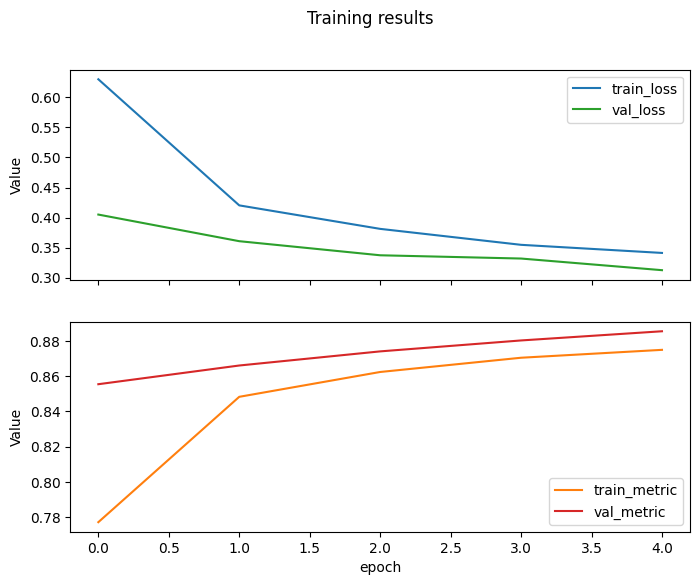

In [4]:
DIRECTORY = "./"
EPOCHS = 5
PATIENCE_EPOCHS = 3

progressbar_theme = RichProgressBarTheme(
    description="black",
    progress_bar="bright_blue",
    progress_bar_finished="bright_blue",
    progress_bar_pulse="bright_blue",
    batch_progress="bright_blue",
    time="red",
    processing_speed="red",
    metrics="green",
)
progressbar_callback = callbacks.RichProgressBar(theme=progressbar_theme)
model_summary_callback = callbacks.RichModelSummary(max_depth=2)
checkpoint_callback = callbacks.ModelCheckpoint(
    filename="best_weights", save_top_k=1, monitor="val_loss", mode="min"
)
early_stopping_callback = callbacks.EarlyStopping(
    monitor="val_loss", mode="min", patience=PATIENCE_EPOCHS
)
swa_callback = callbacks.StochasticWeightAveraging(1e-2)

# Create trainer
trainer = Trainer(
    default_root_dir=DIRECTORY,
    accelerator="auto",
    devices="auto",
    max_epochs=EPOCHS,
    callbacks=[
        progressbar_callback,
        model_summary_callback,
        checkpoint_callback,
        early_stopping_callback,
        swa_callback,
    ],
    logger=CSVLogger(save_dir=DIRECTORY),
    precision="16-mixed",
)

# Train model
trainer.fit(model, fashion_mnist)
plot_training(trainer)

In [5]:
# Test model (with trainer)
checkpoint = checkpoint_callback.best_model_path
model = MNISTModel.load_from_checkpoint(checkpoint)
test_results = trainer.test(model, fashion_mnist)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3557029664516449     │
│        test_metric        │     0.871999979019165     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

Accuracy: 0.871999979019165
Balanced accuracy: 0.871999979019165
Confusion matrix:


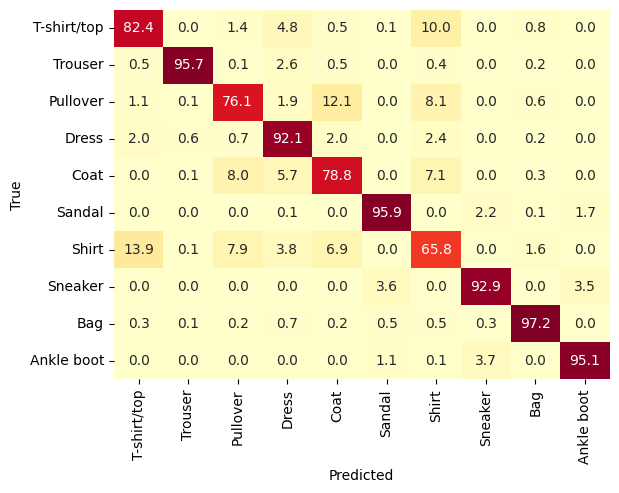

In [6]:
# Test model (without trainer)
checkpoint = checkpoint_callback.best_model_path
model = MNISTModel.load_from_checkpoint(checkpoint)

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
preds = torch.cat(trainer.predict(model, fashion_mnist))
y = fashion_mnist.mnist_test.targets

print(
    "Accuracy:",
    torchmetrics.functional.accuracy(
        preds, y, task="multiclass", num_classes=fashion_mnist.num_classes
    ).item(),
)
print(
    "Balanced accuracy:",
    torchmetrics.functional.accuracy(
        preds,
        y,
        task="multiclass",
        average="macro",
        num_classes=fashion_mnist.num_classes,
    ).item(),
)
print("Confusion matrix:")
cm = sns.heatmap(
    torchmetrics.functional.confusion_matrix(
        preds,
        y,
        task="multiclass",
        normalize="true",
        num_classes=fashion_mnist.num_classes,
    )
    * 100,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    cbar=False,
    xticklabels=classes,
    yticklabels=classes,
)
cm.set(xlabel="Predicted", ylabel="True");

# Production: Lightning

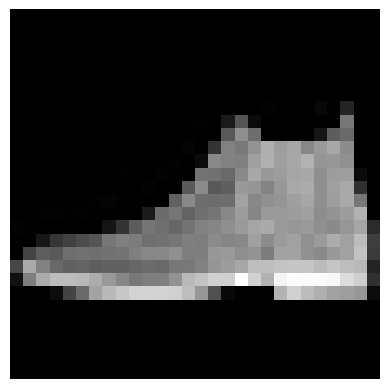

Predicted: "Ankle boot", Actual: "Ankle boot"


In [7]:
checkpoint = checkpoint_callback.best_model_path
model = MNISTModel.load_from_checkpoint(checkpoint)

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=transforms.ToTensor()
)
x, y = test_data[0][0], test_data[0][1]
plt.imshow(x.numpy()[0], cmap="gray")
plt.axis("off")
plt.show()

model.eval()
with torch.inference_mode():
    pred = model(x.to("cuda"))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

# Production: TorchScript
## Save model

In [8]:
checkpoint = checkpoint_callback.best_model_path
model = MNISTModel.load_from_checkpoint(checkpoint)
script = model.to_torchscript()
torch.jit.save(script, "model.pt")

## Load model

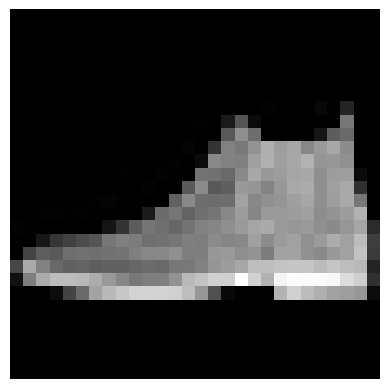

Predicted: "Ankle boot", Actual: "Ankle boot"


In [9]:
model = torch.jit.load("model.pt")


@torch.inference_mode()
def predict(x: torch.Tensor) -> torch.Tensor:
    return model(x)


classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=transforms.ToTensor()
)
x, y = test_data[0][0], test_data[0][1]
plt.imshow(x.numpy()[0], cmap="gray")
plt.axis("off")
plt.show()

pred = predict(x.to("cuda"))
predicted, actual = classes[pred[0].argmax(0)], classes[y]
print(f'Predicted: "{predicted}", Actual: "{actual}"')

# Production: ONNX
## Save model

In [10]:
checkpoint = checkpoint_callback.best_model_path
model = MNISTModel.load_from_checkpoint(checkpoint)
input_sample = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=transforms.ToTensor()
)
input_sample = input_sample[0][0]
model.to_onnx("model.onnx", input_sample, export_params=True)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



## Load model

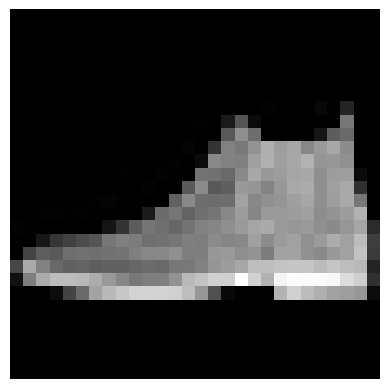

Predicted: "Ankle boot", Actual: "Ankle boot"


In [11]:
ort_session = onnxruntime.InferenceSession("model.onnx")

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=transforms.ToTensor()
)
x, y = test_data[0][0], test_data[0][1]
plt.imshow(x.numpy()[0], cmap="gray")
plt.axis("off")
plt.show()

input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: x.numpy()}
ort_outs = ort_session.run(None, ort_inputs)[0]
predicted, actual = classes[ort_outs[0].argmax(0)], classes[y]
print(f'Predicted: "{predicted}", Actual: "{actual}"')